# Experiments with Zee

* This notebook contains code for experiments with Zee for WiFi radio map construction.

## Imports & Utilities

In [1]:
import sys
import os

# Add paths for resolve 
INDOOR_COMPETITION_20_DIR = os.path.join("..", "indoor-location-competition-20")
sys.path.append(INDOOR_COMPETITION_20_DIR)
CODE_DIR = ".."
sys.path.append(CODE_DIR)

In [2]:
import numpy as np
import pandas as pd
import json
import shapely
import sklearn
import scipy
import shapely.vectorized
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from dataclasses import dataclass, field
from multiprocessing import Pool

%matplotlib inline
from py_indoor_loc.model import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.sensors import compute_earth_acce_heading_ahrs
from py_indoor_loc.utils import rotate, inverse_rotate
from pathlib import Path
from glob import glob
from py_indoor_loc.floor_map import transform_rotation
from compute_f import compute_step_positions
from py_indoor_loc.zee import create_search_grid, SearchGrid
from py_indoor_loc.zee import estimate_heading_offset, init_apf, run_apf
from py_indoor_loc.floor_map import inverse_scale

In [3]:
data_dir = Path(f"../../data/train")
metadata_dir = Path(f"../../data/metadata")

In [4]:
def create_track_waypoints(sensor_ts: np.ndarray, history) -> pd.DataFrame:
  track_waypoints = []

  for step in history:
    step_point = step.particles[step.keep_mask, :2].mean(axis=0).tolist()
    step_time = sensor_ts[step.sample_index]
    track_waypoints.append((step_time, *step_point))

  return pd.DataFrame(track_waypoints, columns=["sys_ts", "x", "y"])

In [5]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df


def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
      "sys_ts":
          "system timestamp",
      "ssid":
          "the network name",
      "bssid":
          "the MAC address of the AP",
      "rssi":
          "RSSI",
      "freq":
          "Frequency",
      "last_seen_ts":
          "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(
        f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}"
    )
  return wifi_df


def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
      "sys_ts": "System timestamp",
      "x": "Coordinate x (meter)",
      "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[
      1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array,
                             columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] -
                     waypoint_df["sys_ts"].values[:-1]) / 1000
    print(
        f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s"
    )

  return waypoint_df


## Test Scenario 1 & 2

In [6]:
experiment_tracks = pd.read_csv("./setup/experiment_tracks.csv")

In [7]:
experiment_tracks["site_id"].unique().shape[0]

8

In [8]:
site_floors = experiment_tracks[["site_id", "floor_id"]].drop_duplicates().values

In [9]:
site_id, floor_id = site_floors[1]

In [10]:
site_floor_experiment_tracks = experiment_tracks.loc[
    (experiment_tracks["site_id"] == site_id) &
    (experiment_tracks["floor_id"] == floor_id)]

print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

track_files = [
  data_dir / site_id / floor_id / (track_id + ".txt")
  for site_id, floor_id, track_id in site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values
]

The number of tracks is: 162


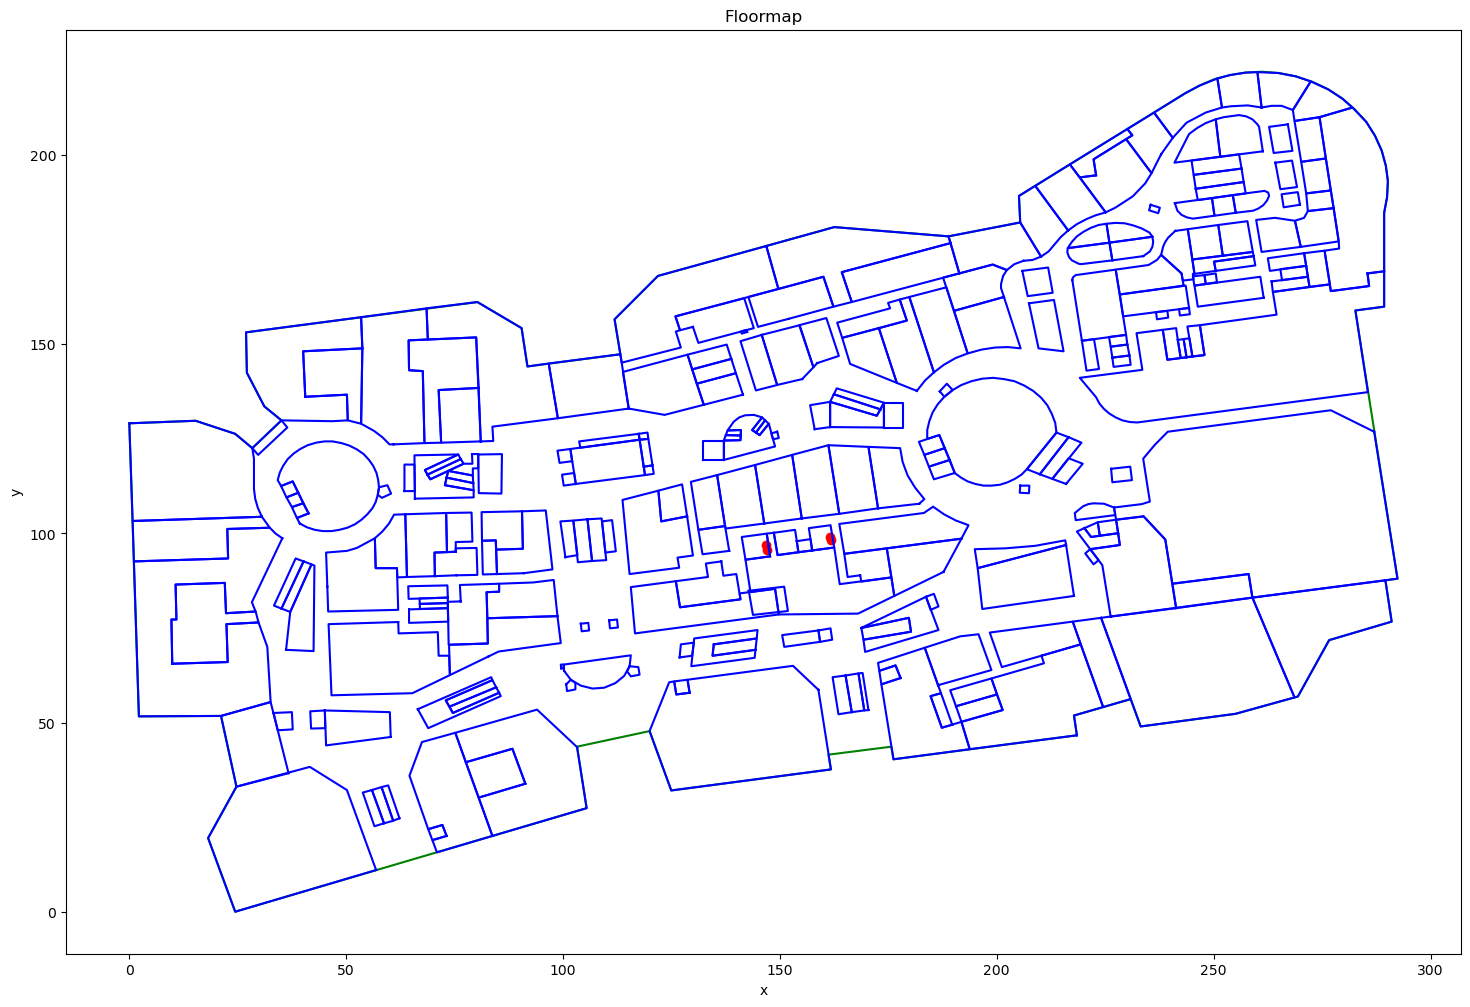

In [12]:
floor_info, floor_map = read_floor_data(str(metadata_dir / site_id / floor_id))

(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map,
                                 floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
path_data_collection = read_data_file(track_files[100])
ax.scatter(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

In [13]:
search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=3.0,
                                 tol=1.0)


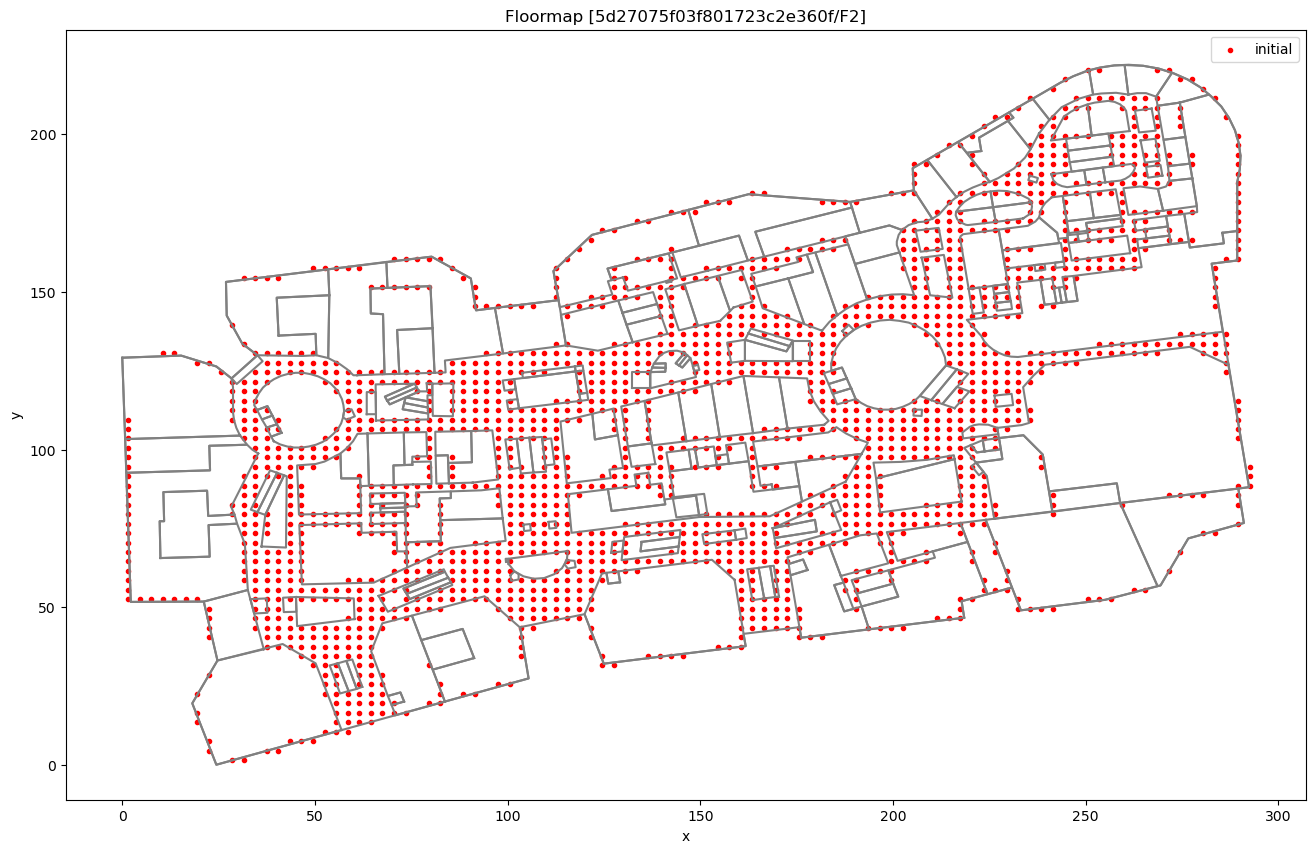

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floormap [{site_id}/{floor_id}]")

# Adding search grid
ax.scatter(search_grid.grid_points[:, 0],
           search_grid.grid_points[:, 1],
           marker=".",
           color="red",
           label="initial")

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [15]:
path_data_collection = read_data_file(track_files[100])

In [16]:
earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
    sensor_acce=path_data_collection.acce,
    sensor_ahrs=path_data_collection.ahrs)


### Experiment: Without Prior Knowledge about the Initial Location

In [17]:
heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
alpha = heading_offset -  earth_heading_arr[:50].mean()

initial_particles = init_apf(search_grid, placement_offset_center=alpha, placement_offset_loc=0.1, n_particles=10000)
history = run_apf(earth_acce_arr, earth_heading_arr, initial_particles, search_grid, verbose=False)

track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0], history)

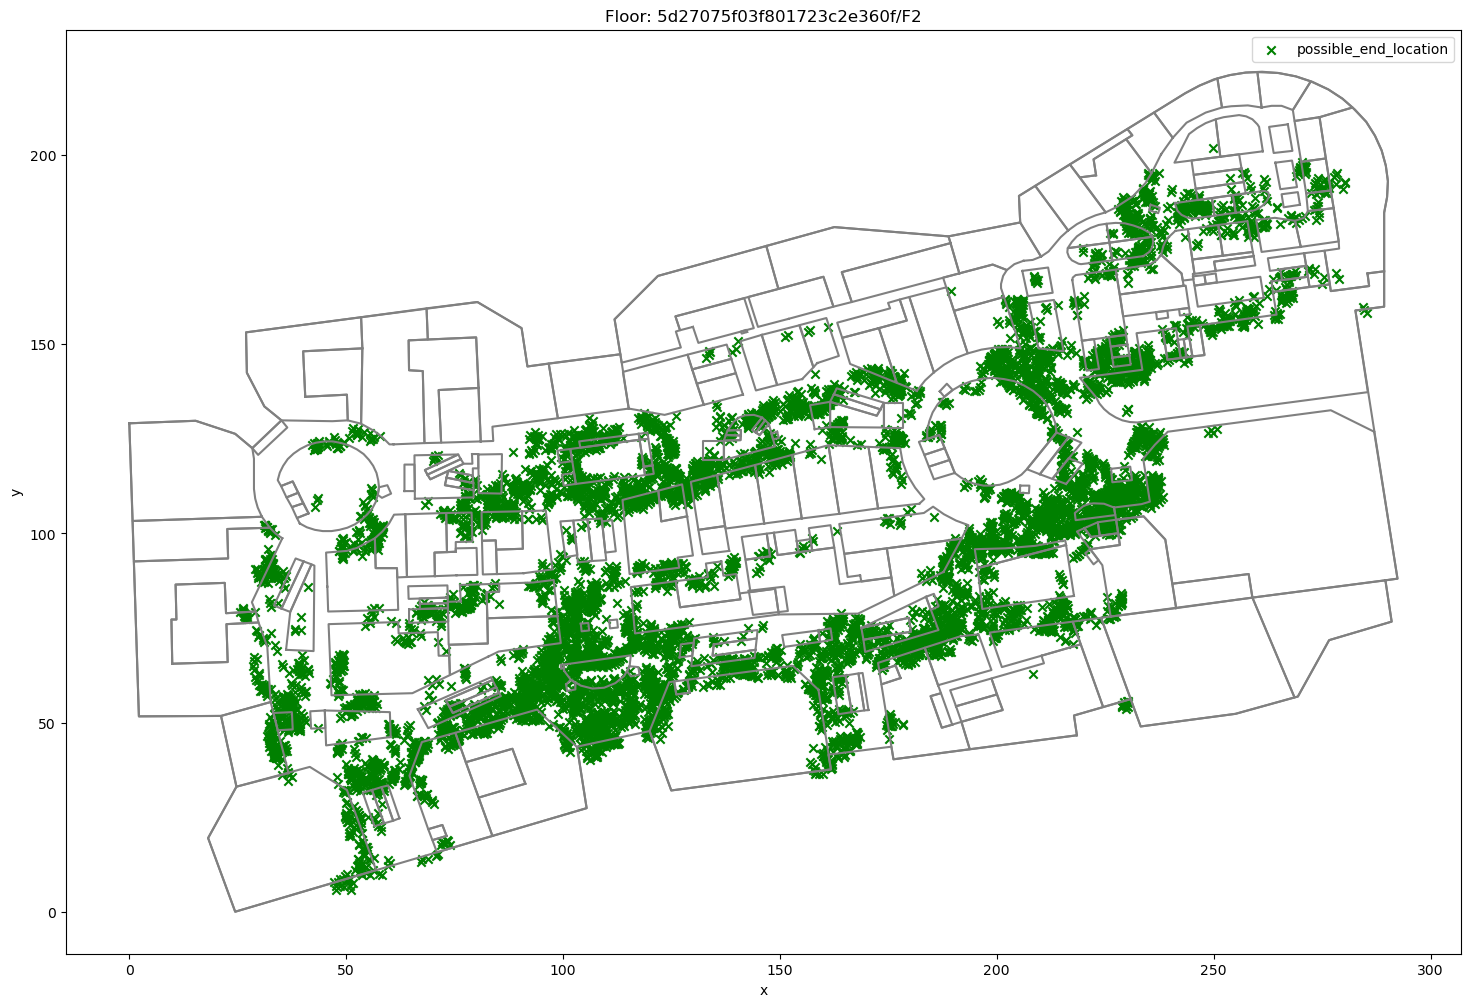

In [18]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
# ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="track")
# ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue")
ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Experiment: Prior Knowledge about the Initial Location

* We assume that the initial location is distributed randomly according to uniform distribution around 10m of the initial waypoint.
* In real-world systems, the distribution of initial location can be estimated by WiFi fingerprinting methods.

In [21]:
heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
alpha = heading_offset - earth_heading_arr[:50].mean()

initial_particles = init_apf(search_grid,
                             placement_offset_center=alpha,
                             placement_offset_loc=0.1,
                             n_particles=10000,
                             initial_location_center=tuple(path_data_collection.waypoint[0, 1:]))
history = run_apf(earth_acce_arr,
                  earth_heading_arr,
                  initial_particles,
                  search_grid,
                  verbose=False)

track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                            history)


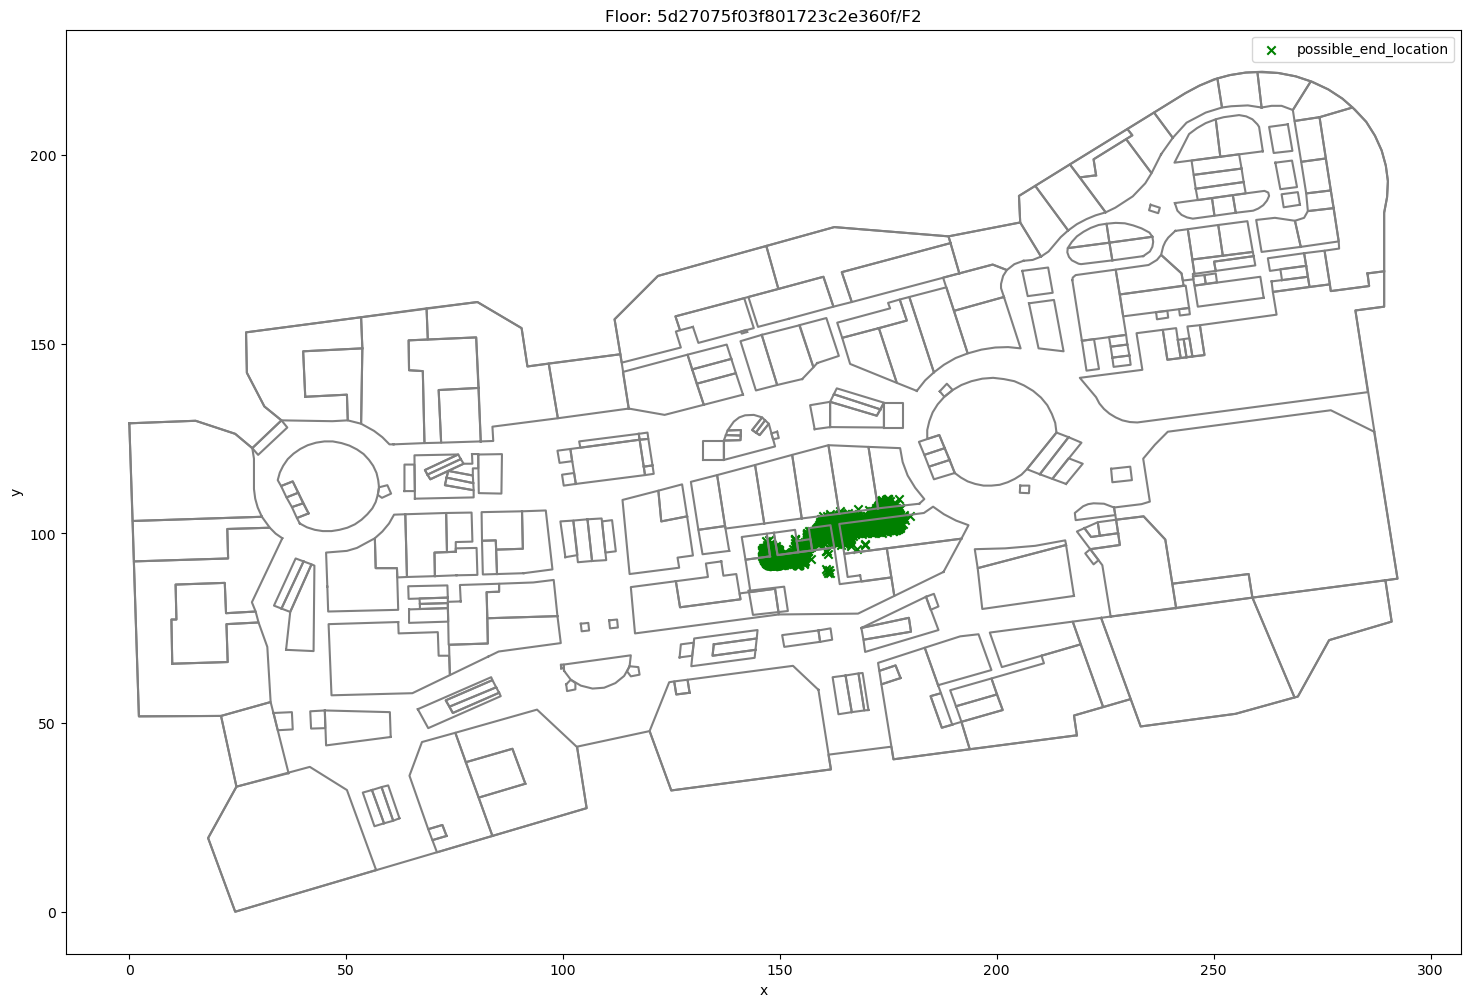

In [22]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
# ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="track")
# ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue")
ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

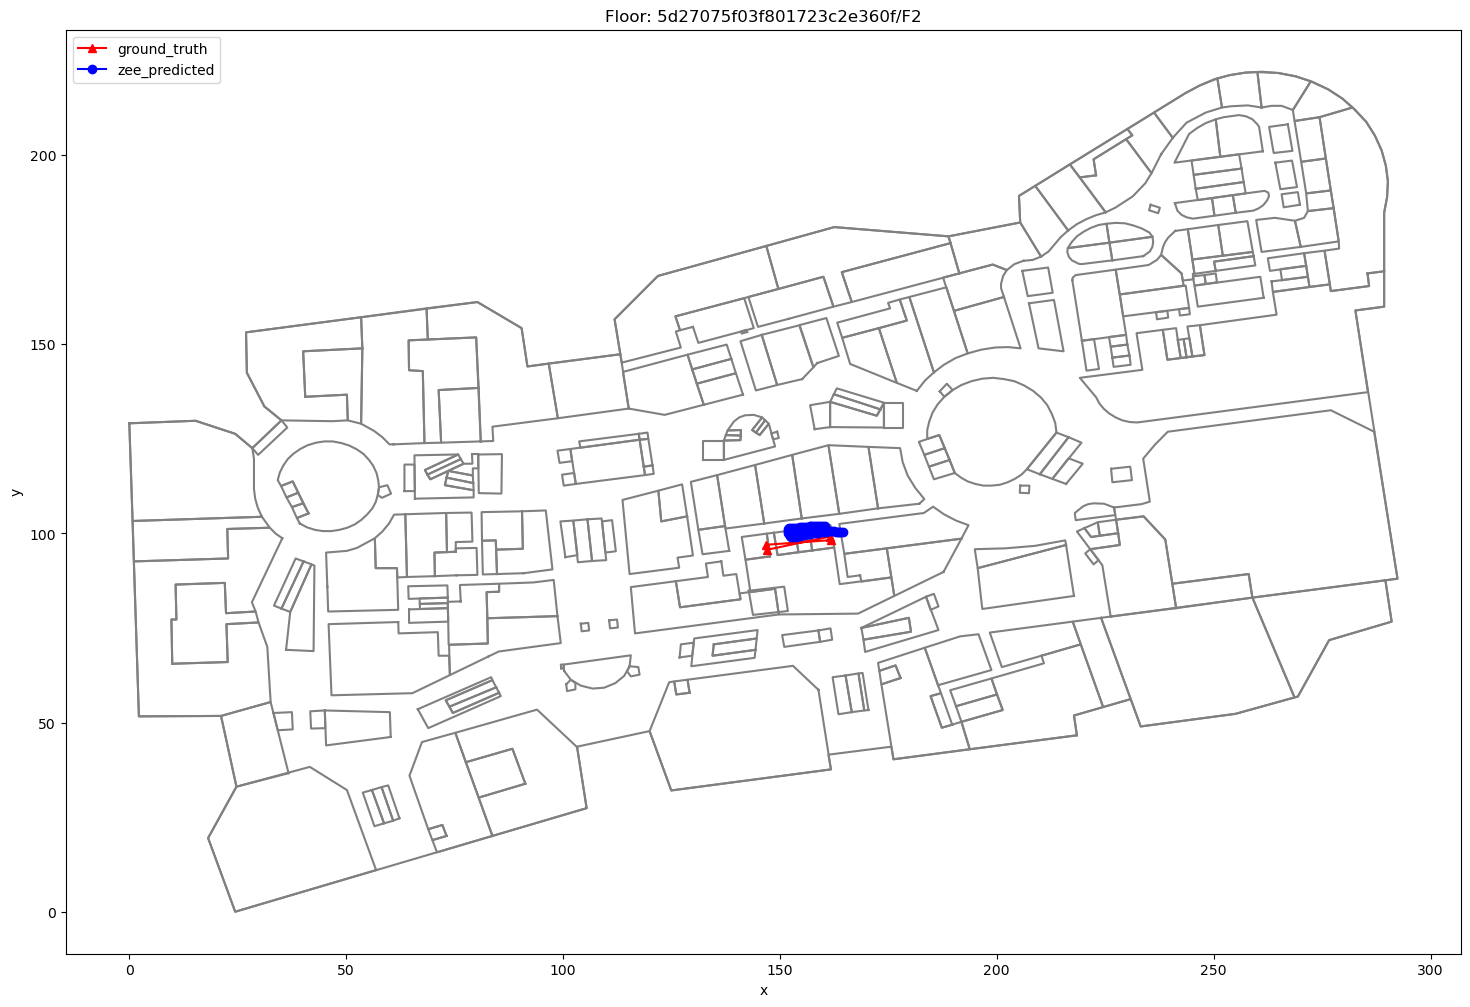

In [23]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="ground_truth")
ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue", label="zee_predicted")
# ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Running Experiments on Multiple Tracks

* Scenario 1: Running Zee without any knowledge about the initial locations of tracks

In [11]:
def run_zee_experiment_no_initial_location(site_id: str, floor_id: str):
  print(f"Running Zee experiments for {site_id}/{floor_id}")

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  floor_info, floor_map = read_floor_data(str(metadata_dir / site_id /
                                              floor_id))

  (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info)

  search_grid = create_search_grid(floor_polygons,
                                   store_polygons,
                                   width_meter,
                                   height_meter,
                                   grid_resolution=3.0,
                                   tol=1.0)

  for train_file in tqdm(track_files):
    path_data_collection = read_data_file(train_file)
    earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
        path_data_collection.acce, path_data_collection.ahrs)
    heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
    alpha = heading_offset - earth_heading_arr[:50].mean()
    initial_particles = init_apf(search_grid, placement_offset_center=alpha, n_particles=10000)
    history = run_apf(earth_acce_arr,
                      earth_heading_arr,
                      initial_particles,
                      search_grid,
                      verbose=False)

    track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                                history)

    track_name = os.path.basename(train_file)[:-len(".txt")]
    os.makedirs(f"../../data/zee_scene_1/train/{site_id}/{floor_id}/",
                exist_ok=True)
    track_waypoints_df.to_csv(
        f"../../data/zee_scene_1/train/{site_id}/{floor_id}/{track_name}_waypoint.csv",
        index=False,
        header=True)


In [60]:
for site_id, floor_id in site_floors[2:]:
  run_zee_experiment_no_initial_location(site_id, floor_id)

Running Zee experiments for 5d2709b303f801723c327472/1F
The number of tracks is: 135


  0%|          | 0/135 [00:00<?, ?it/s]

100%|██████████| 135/135 [08:34<00:00,  3.81s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/B1
The number of tracks is: 80


100%|██████████| 80/80 [03:00<00:00,  2.26s/it]


Running Zee experiments for 5da138b74db8ce0c98bd4774/B1
The number of tracks is: 123


100%|██████████| 123/123 [08:27<00:00,  4.13s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/F3
The number of tracks is: 138


100%|██████████| 138/138 [08:09<00:00,  3.54s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/B1
The number of tracks is: 104


100%|██████████| 104/104 [05:58<00:00,  3.45s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F5
The number of tracks is: 95


100%|██████████| 95/95 [04:40<00:00,  2.95s/it]


Running Zee experiments for 5dc8cea7659e181adb076a3f/F2
The number of tracks is: 75


100%|██████████| 75/75 [03:14<00:00,  2.60s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F1
The number of tracks is: 90


100%|██████████| 90/90 [06:47<00:00,  4.53s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/F4
The number of tracks is: 75


100%|██████████| 75/75 [04:16<00:00,  3.42s/it]


Running Zee experiments for 5d2709d403f801723c32bd39/B1
The number of tracks is: 88


100%|██████████| 88/88 [05:59<00:00,  4.08s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F2
The number of tracks is: 88


100%|██████████| 88/88 [04:41<00:00,  3.20s/it]


Running Zee experiments for 5cd56be3e2acfd2d33b66bae/F1
The number of tracks is: 76


100%|██████████| 76/76 [03:49<00:00,  3.02s/it]


Running Zee experiments for 5dc8cea7659e181adb076a3f/F3
The number of tracks is: 77


100%|██████████| 77/77 [03:18<00:00,  2.58s/it]


Running Zee experiments for 5da1383b4db8ce0c98bc11ab/F2
The number of tracks is: 78


100%|██████████| 78/78 [09:32<00:00,  7.33s/it]


* Scenario 2: Running Zee with prior knowledge about the initial location

In [12]:
def run_zee_experiment_with_initial_location(site_id: str, floor_id: str,
                                             save_output_dir: str):
  print(f"Running Zee experiments for {site_id}/{floor_id}")

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  floor_info, floor_map = read_floor_data(str(metadata_dir / site_id /
                                              floor_id))

  (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info)

  search_grid = create_search_grid(floor_polygons,
                                   store_polygons,
                                   width_meter,
                                   height_meter,
                                   grid_resolution=3.0,
                                   tol=1.0)

  os.makedirs(f"{save_output_dir}/{site_id}/{floor_id}/", exist_ok=True)

  for train_file in tqdm(track_files):
    path_data_collection = read_data_file(train_file)
    earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
        path_data_collection.acce, path_data_collection.ahrs)
    heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
    alpha = heading_offset - earth_heading_arr[:50].mean()
    initial_particles = init_apf(search_grid,
                                 placement_offset_center=alpha,
                                 n_particles=10000,
                                 initial_location_center=tuple(path_data_collection.waypoint[0, 1:]),
                                 initial_location_radius=10.0)
    history = run_apf(earth_acce_arr,
                      earth_heading_arr,
                      initial_particles,
                      search_grid,
                      verbose=False)

    track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                                history)

    track_name = os.path.basename(train_file)[:-len(".txt")]
    track_waypoints_df.to_csv(
        f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_waypoint.csv",
        index=False,
        header=True)


In [61]:
for site_id, floor_id in site_floors[2:]:
  run_zee_experiment_with_initial_location(site_id, floor_id, save_output_dir="../../data/zee_scene_2/train")

Running Zee experiments for 5d2709b303f801723c327472/1F
The number of tracks is: 135


100%|██████████| 135/135 [07:47<00:00,  3.47s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/B1
The number of tracks is: 80


100%|██████████| 80/80 [03:00<00:00,  2.25s/it]


Running Zee experiments for 5da138b74db8ce0c98bd4774/B1
The number of tracks is: 123


100%|██████████| 123/123 [07:07<00:00,  3.48s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/F3
The number of tracks is: 138


100%|██████████| 138/138 [07:33<00:00,  3.29s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/B1
The number of tracks is: 104


100%|██████████| 104/104 [05:25<00:00,  3.13s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F5
The number of tracks is: 95


100%|██████████| 95/95 [04:23<00:00,  2.78s/it]


Running Zee experiments for 5dc8cea7659e181adb076a3f/F2
The number of tracks is: 75


100%|██████████| 75/75 [02:59<00:00,  2.40s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F1
The number of tracks is: 90


100%|██████████| 90/90 [06:26<00:00,  4.30s/it]


Running Zee experiments for 5d27075f03f801723c2e360f/F4
The number of tracks is: 75


100%|██████████| 75/75 [03:59<00:00,  3.20s/it]


Running Zee experiments for 5d2709d403f801723c32bd39/B1
The number of tracks is: 88


100%|██████████| 88/88 [05:40<00:00,  3.87s/it]


Running Zee experiments for 5cd56b6ae2acfd2d33b59ccb/F2
The number of tracks is: 88


100%|██████████| 88/88 [04:18<00:00,  2.93s/it]


Running Zee experiments for 5cd56be3e2acfd2d33b66bae/F1
The number of tracks is: 76


100%|██████████| 76/76 [03:41<00:00,  2.91s/it]


Running Zee experiments for 5dc8cea7659e181adb076a3f/F3
The number of tracks is: 77


100%|██████████| 77/77 [03:02<00:00,  2.37s/it]


Running Zee experiments for 5da1383b4db8ce0c98bc11ab/F2
The number of tracks is: 78


100%|██████████| 78/78 [08:22<00:00,  6.45s/it]


### Compare to Manually Collected Data

* Create the ground-truth dataset

In [30]:
def create_and_save_ground_truth_dataset(site_id: str, floor_id: str, save_output_dir: str):
  os.makedirs(f"{save_output_dir}/{site_id}/{floor_id}/",
                exist_ok=True)

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  for train_file in tqdm(track_files):
    try:
      path_data_collection = read_data_file(train_file)
      waypoint_df = extract_waypoint_df(path_data_collection.waypoint)
      wifi_df = extract_wifi_df(path_data_collection.wifi)

      track_name = os.path.basename(train_file)[:-len(".txt")]
      waypoint_df.to_csv(
          f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_waypoint.csv",
          index=False,
          header=True)
      wifi_df.to_csv(
          f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_wifi.csv",
          index=False,
          header=True)
    except Exception as e:
      print(e)

In [62]:
for site_id, floor_id in site_floors[2:]:
  create_and_save_ground_truth_dataset(site_id, floor_id, save_output_dir="../../data/gt_data")

100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


* Run and report the result

In [13]:
def compare_datasets(site_floor_experiment_tracks: pd.DataFrame, 
                     ground_truth_data_dir: str, 
                     predicted_data_dir: str):

  error_list = []

  for site_id, floor_id, track_id in tqdm(site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values):
    try:
      gt_waypoint_df = pd.read_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_waypoint.csv")
      pred_waypoint_df = pd.read_csv(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_waypoint.csv")

      gt_waypoint_df["sys_ts"] = gt_waypoint_df["sys_ts"].astype(np.int64)
      pred_waypoint_df["sys_ts"] = pred_waypoint_df["sys_ts"].astype(np.int64)

      wifi_df = pd.read_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi.csv")

      gt_wifi_waypoint_df = interpolate_wifi_waypoints(gt_waypoint_df, wifi_df, max_offset_sec=2)
      pred_wifi_waypoint_df = interpolate_wifi_waypoints(pred_waypoint_df, wifi_df, max_offset_sec=2)

      if not os.path.exists(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"):
        gt_wifi_fingerprint_df = pd.merge(wifi_df, gt_wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")
        gt_wifi_fingerprint_df.to_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv", index=False)

      if not os.path.exists(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"):
        pred_wifi_fingerprint_df = pd.merge(wifi_df, pred_wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")
        pred_wifi_fingerprint_df.to_csv(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv", index=False)

      merged = pd.merge(gt_wifi_waypoint_df, pred_wifi_waypoint_df, on="sys_ts", suffixes=["_gt", "_pred"]).drop_duplicates("sys_ts")
      errors = np.linalg.norm(merged[["x_gt", "y_gt"]].values - merged[["x_pred", "y_pred"]].values,
                              axis=1)
      error_list.append(errors)
    except Exception as e:
      print(e)
    
  return np.concatenate(error_list)

In [17]:
errors_scene_1 = compare_datasets(experiment_tracks.sample(frac=0.5), 
                                  ground_truth_data_dir="../../data/gt_data",
                                  predicted_data_dir="../../data/zee_scene_1/train")

  2%|▏         | 16/814 [00:01<01:07, 11.77it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a37cdf065a00069be749_waypoint.csv'


  5%|▍         | 40/814 [00:03<00:57, 13.57it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a175df065a00069be6f7_waypoint.csv'


  6%|▌         | 48/814 [00:04<00:52, 14.53it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a190df065a00069be701_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dc74ab074400064324b4_waypoint.csv'


  7%|▋         | 58/814 [00:05<01:04, 11.71it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc15416bce0a000068ae8d0_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e69d0593fc000669a129_waypoint.csv'


 11%|█▏        | 92/814 [00:09<01:01, 11.81it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c7140593fc0006699eec_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c0536c36940006661fdc_waypoint.csv'


 13%|█▎        | 102/814 [00:09<00:51, 13.75it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a315df065a00069be73d_waypoint.csv'


 14%|█▍        | 113/814 [00:10<00:45, 15.44it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a85483f600068d3815_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6970593fc000669a123_waypoint.csv'


 14%|█▍        | 116/814 [00:10<00:49, 14.10it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12498bce0a000068ae72c_waypoint.csv'


 18%|█▊        | 145/814 [00:13<00:52, 12.82it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc1287fbce0a000068ae757_waypoint.csv'


 18%|█▊        | 149/814 [00:13<00:59, 11.25it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a25483f600068d3811_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2af0593fc0006699f90_waypoint.csv'


 19%|█▉        | 158/814 [00:14<00:55, 11.75it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f570ab0744000643268b_waypoint.csv'


 21%|██        | 168/814 [00:15<00:51, 12.60it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc130994526c70006cc7a59_waypoint.csv'


 21%|██▏       | 175/814 [00:15<00:53, 12.04it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6900593fc000669a121_waypoint.csv'


 27%|██▋       | 222/814 [00:20<00:47, 12.50it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c219ab07440006432352_waypoint.csv'


 28%|██▊       | 229/814 [00:20<00:37, 15.53it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2950593fc0006699f88_waypoint.csv'


 31%|███       | 250/814 [00:22<00:40, 14.04it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde639d5483f600068d380b_waypoint.csv'


 31%|███▏      | 256/814 [00:22<00:38, 14.61it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f55b0593fc000669a1ab_waypoint.csv'


 32%|███▏      | 262/814 [00:23<00:35, 15.39it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f554ab07440006432679_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52418410e00067e67cc_waypoint.csv'


 35%|███▌      | 288/814 [00:25<00:41, 12.67it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a329163b0006be6895_waypoint.csv'


 36%|███▌      | 295/814 [00:26<00:42, 12.25it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12cfa4526c70006cc7a2b_waypoint.csv'


 37%|███▋      | 304/814 [00:28<01:34,  5.41it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2ad0593fc0006699f8e_waypoint.csv'


 39%|███▉      | 316/814 [00:29<00:44, 11.16it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f5740593fc000669a1bd_waypoint.csv'


 39%|███▉      | 320/814 [00:29<00:47, 10.44it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d281ab0744000643241a_waypoint.csv'


 41%|████      | 331/814 [00:30<00:38, 12.56it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12661bce0a000068ae738_waypoint.csv'


 44%|████▎     | 355/814 [00:33<00:43, 10.63it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dcf60593fc000669a013_waypoint.csv'


 44%|████▍     | 361/814 [00:35<02:02,  3.70it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63ab5483f600068d3817_waypoint.csv'


 45%|████▍     | 365/814 [00:35<01:18,  5.71it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2aeab07440006432430_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f54eab07440006432673_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a233df065a00069be71d_waypoint.csv'


 46%|████▋     | 378/814 [00:37<00:53,  8.16it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2730593fc0006699f7c_waypoint.csv'


 48%|████▊     | 393/814 [00:38<00:45,  9.31it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f567ab07440006432683_waypoint.csv'


 49%|████▉     | 399/814 [00:39<00:40, 10.17it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dced0593fc000669a011_waypoint.csv'


 50%|█████     | 407/814 [00:39<00:26, 15.59it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2aa0593fc0006699f8c_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12ae1bce0a000068ae76a_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dcd40593fc000669a009_waypoint.csv'


 50%|█████     | 409/814 [00:39<00:25, 16.15it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c084aee18f0006a0ef21_waypoint.csv'


 52%|█████▏    | 423/814 [00:41<00:30, 13.03it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6a00593fc000669a12b_waypoint.csv'


 55%|█████▍    | 444/814 [00:43<00:30, 12.24it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a289df065a00069be72d_waypoint.csv'


 58%|█████▊    | 469/814 [00:45<00:24, 13.94it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f56a0593fc000669a1b3_waypoint.csv'


 60%|█████▉    | 485/814 [00:46<00:25, 12.81it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a18118410e00067e677e_waypoint.csv'


 61%|██████    | 494/814 [00:47<00:27, 11.47it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc128804526c70006cc7a08_waypoint.csv'


 63%|██████▎   | 516/814 [00:49<00:20, 14.29it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a1e3df065a00069be707_waypoint.csv'


 64%|██████▍   | 525/814 [00:51<00:35,  8.03it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a37218410e00067e67c0_waypoint.csv'


 65%|██████▌   | 531/814 [00:51<00:27, 10.12it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dce0ab074400064324ba_waypoint.csv'


 66%|██████▌   | 537/814 [00:52<00:24, 11.31it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52018410e00067e67c4_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a65483f600068d3813_waypoint.csv'


 67%|██████▋   | 548/814 [00:53<00:21, 12.35it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a36618410e00067e67be_waypoint.csv'


 70%|██████▉   | 568/814 [00:55<00:24, 10.18it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f56bab07440006432685_waypoint.csv'


 70%|███████   | 570/814 [00:55<00:21, 11.34it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a15483f600068d380f_waypoint.csv'


 71%|███████   | 579/814 [00:56<00:20, 11.28it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d286ab0744000643241c_waypoint.csv'


 72%|███████▏  | 585/814 [00:56<00:17, 13.06it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2830593fc0006699f80_waypoint.csv'


 77%|███████▋  | 624/814 [00:59<00:10, 17.68it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2acab0744000643242e_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c712ab0744000643239e_waypoint.csv'


 79%|███████▊  | 639/814 [01:00<00:12, 14.47it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e69b0593fc000669a127_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a929163b0006be689d_waypoint.csv'


 80%|███████▉  | 649/814 [01:01<00:12, 13.36it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc13c4d4526c70006cc7ac4_waypoint.csv'


 80%|████████  | 655/814 [01:01<00:09, 17.22it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c048aee18f0006a0ef16_waypoint.csv'


 82%|████████▏ | 671/814 [01:02<00:08, 17.23it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc11fa0bce0a000068ae6ea_waypoint.csv'


 84%|████████▎ | 680/814 [01:03<00:10, 13.27it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63b05483f600068d381f_waypoint.csv'


 85%|████████▍ | 689/814 [01:04<00:09, 12.64it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63995483f600068d3807_waypoint.csv'


 88%|████████▊ | 717/814 [01:07<00:20,  4.70it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a1eedf065a00069be70d_waypoint.csv'


 91%|█████████ | 737/814 [01:10<00:05, 13.94it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dc6dab074400064324b2_waypoint.csv'


 92%|█████████▏| 749/814 [01:12<00:05, 12.87it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a284df065a00069be72b_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52318410e00067e67ca_waypoint.csv'


 94%|█████████▎| 763/814 [01:12<00:02, 17.42it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a2f518410e00067e67b2_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12be44526c70006cc7a1d_waypoint.csv'


 94%|█████████▍| 766/814 [01:13<00:02, 17.46it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc1473a4526c70006cc7b1e_waypoint.csv'


 95%|█████████▍| 772/814 [01:13<00:02, 17.40it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dcdc0593fc000669a00b_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2a4ab07440006432428_waypoint.csv'


 96%|█████████▌| 778/814 [01:14<00:02, 14.15it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e679ab074400064325b3_waypoint.csv'


100%|██████████| 814/814 [01:17<00:00, 10.54it/s]


In [18]:
errors_scene_1.mean(), errors_scene_1.std(), np.percentile(errors_scene_1, [5, 25, 50, 75, 95])

(65.66325248114485,
 40.273747952867424,
 array([ 14.42367305,  36.00752731,  59.10746049,  87.0892754 ,
        136.24727761]))

* Scenario 2

In [19]:
errors_scene_2 = compare_datasets(experiment_tracks.sample(frac=0.5), 
                                  ground_truth_data_dir="../../data/gt_data",
                                  predicted_data_dir="../../data/zee_scene_2/train")

  1%|          | 10/814 [00:00<00:24, 32.21it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f56a0593fc000669a1b3_waypoint.csv'


  2%|▏         | 19/814 [00:00<00:34, 23.29it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc15416bce0a000068ae8d0_waypoint.csv'


  3%|▎         | 25/814 [00:01<00:34, 22.85it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12cfa4526c70006cc7a2b_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a183df065a00069be6f9_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc13c4d4526c70006cc7ac4_waypoint.csv'


  7%|▋         | 59/814 [00:02<00:26, 28.34it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f554ab07440006432679_waypoint.csv'


  9%|▉         | 73/814 [00:02<00:26, 28.01it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6adab074400064325d0_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc121684526c70006cc79fb_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2aa0593fc0006699f8c_waypoint.csv'


 11%|█         | 89/814 [00:03<00:29, 24.93it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a18118410e00067e677e_waypoint.csv'


 13%|█▎        | 105/814 [00:04<00:36, 19.59it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a28b18410e00067e67ac_waypoint.csv'


 18%|█▊        | 147/814 [00:05<00:16, 39.31it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a190df065a00069be701_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c21f0593fc0006699e9f_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63ab5483f600068d3817_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d28f0593fc0006699f84_waypoint.csv'


 21%|██▏       | 173/814 [00:06<00:15, 40.44it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6a6ab074400064325ca_waypoint.csv'


 25%|██▍       | 200/814 [00:07<00:18, 34.10it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a329163b0006be6895_waypoint.csv'


 26%|██▌       | 210/814 [00:07<00:17, 35.46it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12be44526c70006cc7a1d_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dcd0ab074400064324b8_waypoint.csv'


 27%|██▋       | 221/814 [00:08<00:15, 38.08it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12661bce0a000068ae738_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12e354526c70006cc7a3d_waypoint.csv'


 28%|██▊       | 229/814 [00:08<00:17, 32.77it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2af0593fc0006699f90_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f576ab0744000643268f_waypoint.csv'


 30%|██▉       | 243/814 [00:08<00:12, 45.06it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc12498bce0a000068ae72c_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc11fa0bce0a000068ae6ea_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a729163b0006be689b_waypoint.csv'


 31%|███       | 253/814 [00:08<00:12, 43.15it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c0646c36940006661fe0_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc1287fbce0a000068ae757_waypoint.csv'


 33%|███▎      | 265/814 [00:09<00:12, 44.94it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c712ab0744000643239e_waypoint.csv'


 36%|███▌      | 289/814 [00:09<00:15, 34.89it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dcdc0593fc000669a00b_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6a00593fc000669a12b_waypoint.csv'


 37%|███▋      | 298/814 [00:10<00:15, 33.05it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6af0593fc000669a132_waypoint.csv'


 39%|███▊      | 315/814 [00:10<00:17, 28.46it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e6a4ab074400064325c8_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dd000593fc000669a015_waypoint.csv'


 46%|████▌     | 373/814 [00:13<00:20, 21.92it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc1408abce0a000068ae816_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d28a0593fc0006699f82_waypoint.csv'


 48%|████▊     | 387/814 [00:13<00:17, 24.23it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a929163b0006be689d_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dc6dab074400064324b2_waypoint.csv'


 49%|████▉     | 400/814 [00:14<00:19, 21.58it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a2f518410e00067e67b2_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f55b0593fc000669a1ab_waypoint.csv'


 51%|█████     | 416/814 [00:14<00:15, 26.27it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a29918410e00067e67b0_waypoint.csv'


 61%|██████    | 493/814 [00:18<00:12, 25.86it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2ad0593fc0006699f8e_waypoint.csv'


 61%|██████▏   | 500/814 [00:18<00:14, 20.99it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f567ab07440006432683_waypoint.csv'


 62%|██████▏   | 508/814 [00:18<00:12, 25.13it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a315df065a00069be73d_waypoint.csv'


 65%|██████▍   | 526/814 [00:19<00:10, 27.04it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde639d5483f600068d380b_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52318410e00067e67ca_waypoint.csv'


 65%|██████▌   | 533/814 [00:20<00:11, 24.30it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f5740593fc000669a1bd_waypoint.csv'


 68%|██████▊   | 553/814 [00:20<00:08, 29.14it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d29aab07440006432426_waypoint.csv'


 69%|██████▉   | 561/814 [00:20<00:08, 31.23it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a23818410e00067e679c_waypoint.csv'


 70%|██████▉   | 568/814 [00:21<00:09, 25.15it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a1e3df065a00069be707_waypoint.csv'


 75%|███████▌  | 612/814 [00:23<00:15, 13.03it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63995483f600068d3807_waypoint.csv'


 79%|███████▉  | 643/814 [00:24<00:06, 28.22it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c04caee18f0006a0ef18_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a36618410e00067e67be_waypoint.csv'


 80%|████████  | 652/814 [00:24<00:05, 30.92it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a22ddf065a00069be719_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5daeefb5e415cd00066294e0_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a1e818410e00067e678c_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d2950593fc0006699f88_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c70f0593fc0006699eea_waypoint.csv'


 82%|████████▏ | 669/814 [00:25<00:05, 25.44it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52018410e00067e67c4_waypoint.csv'


 83%|████████▎ | 678/814 [00:25<00:04, 30.95it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c0726c36940006661fe4_waypoint.csv'


 85%|████████▌ | 693/814 [00:26<00:03, 34.46it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc13d854526c70006cc7ad2_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a289df065a00069be72d_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c7260593fc0006699eee_waypoint.csv'


 88%|████████▊ | 714/814 [00:26<00:01, 51.63it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dd04ab074400064324c4_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c07c6c36940006661fe6_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c722ab074400064323a0_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6f54eab07440006432673_waypoint.csv'


 91%|█████████ | 737/814 [00:27<00:01, 41.20it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63a85483f600068d3815_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e69d0593fc000669a129_waypoint.csv'


 95%|█████████▍| 772/814 [00:28<00:01, 26.05it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6d27aab07440006432418_waypoint.csv'


 97%|█████████▋| 788/814 [00:29<00:00, 30.61it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a52418410e00067e67cc_waypoint.csv'


 98%|█████████▊| 796/814 [00:29<00:00, 26.06it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a37cdf065a00069be749_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6dced0593fc000669a011_waypoint.csv'


100%|██████████| 814/814 [00:30<00:00, 26.77it/s]

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6e68dab074400064325c4_waypoint.csv'


In [20]:
errors_scene_2.mean(), errors_scene_2.std(), np.percentile(errors_scene_2, [5, 25, 50, 75, 95])

(17.996953865285423,
 19.08288660669275,
 array([ 2.10226901,  5.75291393, 11.43939766, 23.51572486, 55.33447977]))

In [21]:
sample_count_1 = np.bincount((np.floor(errors_scene_1 / 2) * 2).astype(np.int32)).astype(np.float32)
sample_count_1 /= sample_count_1.sum()
sample_cumsum_1 = np.cumsum(sample_count_1)

sample_count_2 = np.bincount((np.floor(errors_scene_2 / 2) * 2).astype(np.int32)).astype(np.float32)
sample_count_2 /= sample_count_2.sum()
sample_cumsum_2 = np.cumsum(sample_count_2)

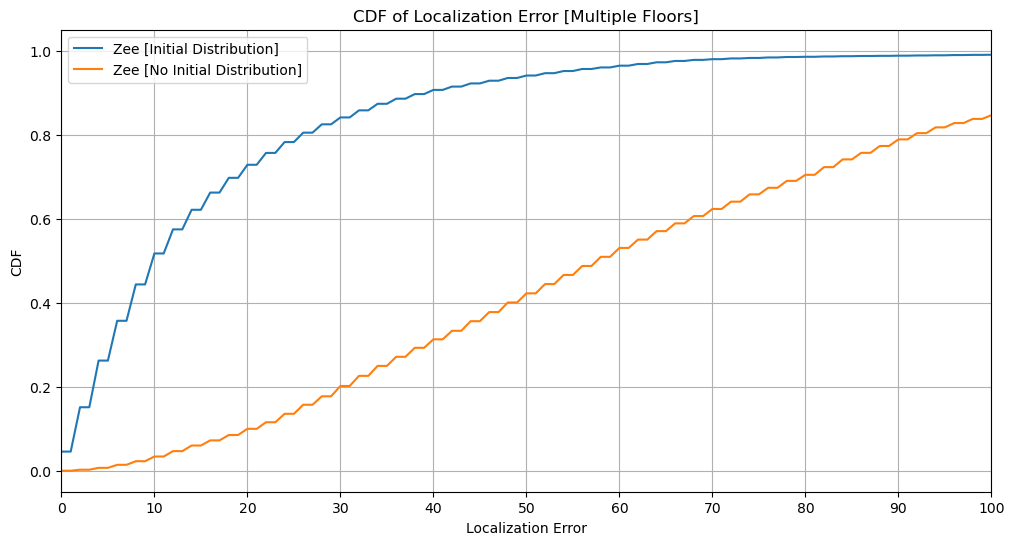

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(sample_cumsum_2, label="Zee [Initial Distribution]")
ax.plot(sample_cumsum_1, label="Zee [No Initial Distribution]")

ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))

ax.set_title(f"CDF of Localization Error [Multiple Floors]")
ax.set_xlabel("Localization Error")
ax.set_ylabel("CDF")
ax.legend()
ax.grid()

# ax.hist(errors_scene_1, bins=50, label="Zee [no prior]", cumulative=True, density=True, histtype="step")
# ax.hist(errors_scene_2, bins=50, label="Zee [with prior]", cumulative=True, density=True, histtype="step")

plt.show()

## Scenario 3: Testing ML model performance

In [23]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list, extract_fingerprint_df, read_wifi_location_df
from py_indoor_loc.knn.preprocessing import extract_train_test
from py_indoor_loc.knn.experiment import run_knn_regression_experiments

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str) -> list[str]:
  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}_wifi_fingerprint.csv"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [53]:
train_tracks, test_tracks = train_test_split(
    site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values,
    test_size=0.3,
    shuffle=True,
    random_state=29)


* Ground-truth train dataset + ground-truth test dataset

In [26]:
!mkdir -p ../../data/zee_scene_3

In [27]:
gt_data_dir = Path("../../data/gt_data")
pred_data_dir = Path("../../data/zee_scene_2/train")

In [28]:
def read_wifi_location_df_list(file_path_list: list[str]) -> list[pd.DataFrame]:
  frames = []
  for file_path in file_path_list:
    try:
      frames.append(read_wifi_location_df(file_path))
    except Exception as e:
      print(e)
  return frames

In [31]:
for site_id, floor_id in site_floors:
  site_floor_experiment_tracks = experiment_tracks.loc[
    (experiment_tracks["site_id"] == site_id) &
    (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  train_tracks, test_tracks = train_test_split(
      site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values,
      test_size=0.3,
      shuffle=True,
      random_state=29)

  failed = []

  try:
    train_files = [
      str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
      for site_id, floor_id, track_id in train_tracks
    ]
    test_files = [
      str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
      for site_id, floor_id, track_id in test_tracks
    ]

    train_wifi_location_df_list = read_wifi_location_df_list(train_files)
    test_wifi_location_df_list = read_wifi_location_df_list(test_files)

    train_wifi_location_df = pd.concat(train_wifi_location_df_list)
    test_wifi_location_df = pd.concat(test_wifi_location_df_list)

    print(f"Train: n_files={len(train_files)}, n_records={train_wifi_location_df.shape[0]}")
    print(f"Test: n_files={len(test_files)}, n_records={test_wifi_location_df.shape[0]}")

    train_fingerprint_df, train_bssid = extract_fingerprint_df(train_wifi_location_df_list)
    test_fingerprint_df, test_bssid = extract_fingerprint_df(test_wifi_location_df_list)
    X_train, y_train, X_test, y_test, bssid_vector = extract_train_test(
      train_fingerprint_df, train_bssid,
      test_fingerprint_df, test_bssid
    )
    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    print(f"The number of train samples: {X_train.shape[0]}")
    print(f"The number of test samples: {X_test.shape[0]}")
    options_min_rss = range(-100, -70, 5)
    options_metric = ["l1", "l2", "cosine"]
    options_n_neighbors = [1, 2, 4, 8]

    results = run_knn_regression_experiments(
      X_train,
      y_train,
      X_test,
      y_test,
      options_metric=options_metric,
      options_n_neighbors=options_n_neighbors,
      options_min_rss=options_min_rss
    )
    result_df = pd.DataFrame(results)
    result_df.to_csv(os.path.join("../../data/zee_scene_3/", f"gt_{site_id}_{floor_id}.csv"), index=False)

  except Exception as e:
    print(f"Failed to run kNN experiment for {site_id}/{floor_id}, caused by {type(e)}: {str(e)}")
    failed.append((site_id, floor_id))


The number of tracks is: 144
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dc1274dbce0a000068ae748_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde63ab5483f600068d3817_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5dde639d5483f600068d380b_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a21fdf065a00069be713_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da6c0506c36940006661fda_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a35edf065a00069be73f_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F1/5da9a1e818410e00067e678c_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../dat

100%|██████████| 72/72 [06:36<00:00,  5.51s/it]


The number of tracks is: 135
Train: n_files=94, n_records=626906
Test: n_files=41, n_records=342953
The number of train samples: 3884
The number of test samples: 2016


100%|██████████| 72/72 [01:57<00:00,  1.64s/it]


The number of tracks is: 80
Train: n_files=56, n_records=219879
Test: n_files=24, n_records=82138
The number of train samples: 1310
The number of test samples: 563


100%|██████████| 72/72 [00:12<00:00,  5.81it/s]


The number of tracks is: 123
Train: n_files=86, n_records=282936
Test: n_files=37, n_records=167360
The number of train samples: 2590
The number of test samples: 1398


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


The number of tracks is: 138
Train: n_files=96, n_records=757627
Test: n_files=42, n_records=333891
The number of train samples: 2629
The number of test samples: 1148


100%|██████████| 72/72 [03:07<00:00,  2.61s/it]


The number of tracks is: 104
Train: n_files=72, n_records=356290
Test: n_files=32, n_records=165167
The number of train samples: 3336
The number of test samples: 1809


100%|██████████| 72/72 [01:41<00:00,  1.41s/it]


The number of tracks is: 95
Train: n_files=66, n_records=711224
Test: n_files=29, n_records=313559
The number of train samples: 3181
The number of test samples: 1325


100%|██████████| 72/72 [01:45<00:00,  1.46s/it]


The number of tracks is: 75
Train: n_files=52, n_records=215746
Test: n_files=23, n_records=83871
The number of train samples: 1279
The number of test samples: 521


100%|██████████| 72/72 [00:18<00:00,  3.84it/s]


The number of tracks is: 90
Train: n_files=63, n_records=847520
Test: n_files=27, n_records=229222
The number of train samples: 2690
The number of test samples: 899


100%|██████████| 72/72 [01:54<00:00,  1.59s/it]


The number of tracks is: 75
Train: n_files=52, n_records=556824
Test: n_files=23, n_records=251378
The number of train samples: 1882
The number of test samples: 897


100%|██████████| 72/72 [01:35<00:00,  1.33s/it]


The number of tracks is: 88
Train: n_files=61, n_records=242717
Test: n_files=27, n_records=89626
The number of train samples: 2946
The number of test samples: 1312


100%|██████████| 72/72 [00:23<00:00,  3.03it/s]


The number of tracks is: 88
Train: n_files=61, n_records=643544
Test: n_files=27, n_records=294531
The number of train samples: 2343
The number of test samples: 1066


100%|██████████| 72/72 [01:59<00:00,  1.66s/it]


The number of tracks is: 76
Train: n_files=53, n_records=645667
Test: n_files=23, n_records=245818
The number of train samples: 5289
The number of test samples: 1986


100%|██████████| 72/72 [04:30<00:00,  3.76s/it]


The number of tracks is: 77
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dccee01c04f060006e6e2d2_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dcce1dcc04f060006e6e250_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dcfe21994e4900006125a18_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dccee05c04f060006e6e2d6_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dccf176c04f060006e6e318_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dcce1d7c04f060006e6e24c_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5dc8cea7659e181adb076a3f/F3/5dcfe21c878f3300066c7164_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data

100%|██████████| 72/72 [00:14<00:00,  4.93it/s]


The number of tracks is: 78
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd4e11c50e04e0006f55faa_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd3a67e44333f00067aa5f9_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd26a8a44333f00067a99d7_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd4c89b44333f00067ab1a0_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd2790b878f3300066c833d_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd4e94ad48f840006f145d5_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5da1383b4db8ce0c98bc11ab/F2/5dd274d7878f3300066c831b_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data

100%|██████████| 72/72 [00:35<00:00,  2.00it/s]


* Passive crowdsourced train dataset + ground-truth test dataset

In [58]:
for site_id, floor_id in site_floors:
  site_floor_experiment_tracks = experiment_tracks.loc[
    (experiment_tracks["site_id"] == site_id) &
    (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  train_tracks, test_tracks = train_test_split(
      site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values,
      test_size=0.3,
      shuffle=True,
      random_state=29)

  failed = []

  try:
    train_files = [
      str(pred_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
      for site_id, floor_id, track_id in train_tracks
    ]
    test_files = [
      str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
      for site_id, floor_id, track_id in test_tracks
    ]

    train_wifi_location_df_list = read_wifi_location_df_list(train_files)
    test_wifi_location_df_list = read_wifi_location_df_list(test_files)

    train_wifi_location_df = pd.concat(train_wifi_location_df_list)
    test_wifi_location_df = pd.concat(test_wifi_location_df_list)

    print(f"Train: n_files={len(train_files)}, n_records={train_wifi_location_df.shape[0]}")
    print(f"Test: n_files={len(test_files)}, n_records={test_wifi_location_df.shape[0]}")

    train_fingerprint_df, train_bssid = extract_fingerprint_df(train_wifi_location_df_list)
    test_fingerprint_df, test_bssid = extract_fingerprint_df(test_wifi_location_df_list)
    X_train, y_train, X_test, y_test, bssid_vector = extract_train_test(
      train_fingerprint_df, train_bssid,
      test_fingerprint_df, test_bssid
    )
    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    print(f"The number of train samples: {X_train.shape[0]}")
    print(f"The number of test samples: {X_test.shape[0]}")
    options_min_rss = range(-100, -70, 5)
    options_metric = ["l1", "l2", "cosine"]
    options_n_neighbors = [1, 2, 4, 8]

    results = run_knn_regression_experiments(
      X_train,
      y_train,
      X_test,
      y_test,
      options_metric=options_metric,
      options_n_neighbors=options_n_neighbors,
      options_min_rss=options_min_rss
    )
    result_df = pd.DataFrame(results)
    result_df.to_csv(os.path.join("../../data/zee_scene_3/", f"pred_{site_id}_{floor_id}.csv"), index=False)

  except Exception as e:
    print(f"Failed to run kNN experiment for {site_id}/{floor_id}, caused by {type(e)}: {str(e)}")
    failed.append((site_id, floor_id))


The number of tracks is: 144
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5dc1274dbce0a000068ae748_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5dde63ab5483f600068d3817_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5dde639d5483f600068d380b_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5da9a21fdf065a00069be713_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5da6c0506c36940006661fda_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5da9a35edf065a00069be73f_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F1/5da9a1e818410e00067e678c

100%|██████████| 72/72 [06:03<00:00,  5.05s/it]


The number of tracks is: 135
Train: n_files=94, n_records=665587
Test: n_files=41, n_records=342953
The number of train samples: 4111
The number of test samples: 2016


100%|██████████| 72/72 [02:54<00:00,  2.42s/it]


The number of tracks is: 80
Train: n_files=56, n_records=223495
Test: n_files=24, n_records=82138
The number of train samples: 1334
The number of test samples: 563


100%|██████████| 72/72 [00:13<00:00,  5.21it/s]


The number of tracks is: 123
Train: n_files=86, n_records=282521
Test: n_files=37, n_records=167360
The number of train samples: 2596
The number of test samples: 1398


100%|██████████| 72/72 [01:18<00:00,  1.09s/it]


The number of tracks is: 138
Train: n_files=96, n_records=762968
Test: n_files=42, n_records=333891
The number of train samples: 2641
The number of test samples: 1148


100%|██████████| 72/72 [03:54<00:00,  3.25s/it]


The number of tracks is: 104
Train: n_files=72, n_records=359687
Test: n_files=32, n_records=165167
The number of train samples: 3362
The number of test samples: 1809


100%|██████████| 72/72 [01:52<00:00,  1.56s/it]


The number of tracks is: 95
Train: n_files=66, n_records=711105
Test: n_files=29, n_records=313559
The number of train samples: 3185
The number of test samples: 1325


100%|██████████| 72/72 [01:44<00:00,  1.45s/it]


The number of tracks is: 75
Train: n_files=52, n_records=215176
Test: n_files=23, n_records=83871
The number of train samples: 1276
The number of test samples: 521


100%|██████████| 72/72 [00:18<00:00,  3.94it/s]


The number of tracks is: 90
Train: n_files=63, n_records=858919
Test: n_files=27, n_records=229222
The number of train samples: 2727
The number of test samples: 899


100%|██████████| 72/72 [02:13<00:00,  1.85s/it]


The number of tracks is: 75
Train: n_files=52, n_records=558977
Test: n_files=23, n_records=251378
The number of train samples: 1887
The number of test samples: 897


100%|██████████| 72/72 [01:58<00:00,  1.65s/it]


The number of tracks is: 88
Train: n_files=61, n_records=241593
Test: n_files=27, n_records=89626
The number of train samples: 2930
The number of test samples: 1312


100%|██████████| 72/72 [00:23<00:00,  3.09it/s]


The number of tracks is: 88
Train: n_files=61, n_records=647562
Test: n_files=27, n_records=294531
The number of train samples: 2355
The number of test samples: 1066


100%|██████████| 72/72 [02:16<00:00,  1.90s/it]


The number of tracks is: 76
Train: n_files=53, n_records=677406
Test: n_files=23, n_records=245818
The number of train samples: 5521
The number of test samples: 1986


100%|██████████| 72/72 [05:26<00:00,  4.54s/it]


The number of tracks is: 77
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dd7a86ac5b77e0006b16ab9_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dccee01c04f060006e6e2d2_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dd7a6249191710006b567f7_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dcce1e1757dea00060802aa_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dccd75bc04f060006e6e0ff_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dcce1dcc04f060006e6e250_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5dc8cea7659e181adb076a3f/F3/5dcfe21994e4900006125a18_

100%|██████████| 72/72 [00:14<00:00,  4.92it/s]


The number of tracks is: 78
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd274e3878f3300066c831f_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd4e125d48f840006f14564_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd4e87150e04e0006f56023_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd4e11c50e04e0006f55faa_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd274d144333f00067a9a26_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd3a67e44333f00067aa5f9_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5da1383b4db8ce0c98bc11ab/F2/5dd26a8a44333f00067a99d7_

100%|██████████| 72/72 [00:19<00:00,  3.69it/s]


* Some Analysis

In [35]:
result_df = pd.read_csv("../../data/zee_scene_3/gt_5cd56b6ae2acfd2d33b59ccb_B1.csv")

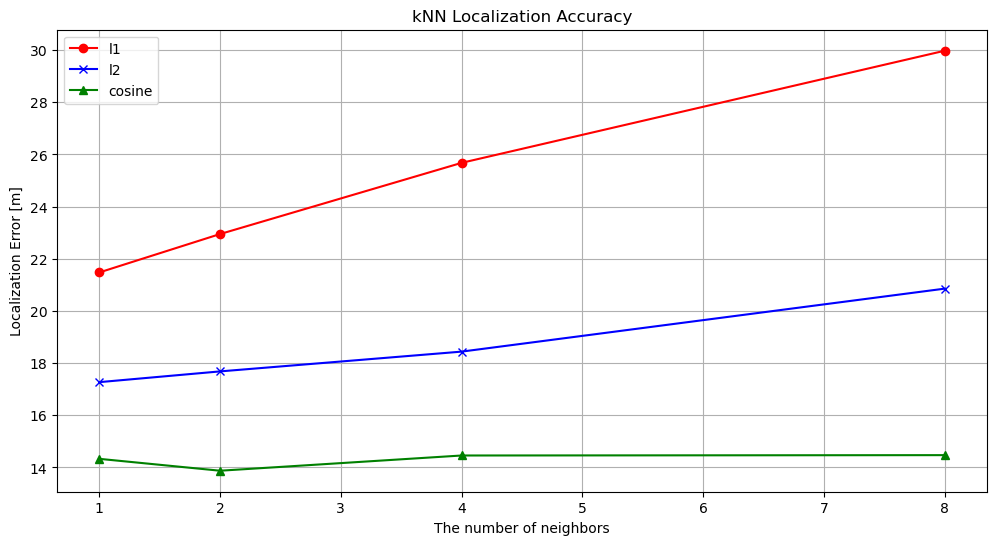

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = result_df.loc[(result_df["param_min_rss"] == -85) & (result_df["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()

In [37]:
result_df[result_df["mean"] == result_df["mean"].min()]

,count,mean,std,p5,p10,p25,p50,p75,p90,p95,param_min_rss,param_metric,param_n_neighbors
11,1809,11.539948,8.910936,2.161538,2.991181,5.210819,9.077947,14.91579,23.443319,31.570123,-100,cosine,8


* Zee

In [40]:
result_df = pd.read_csv("../../data/zee_scene_3/pred_5cd56b6ae2acfd2d33b59ccb_B1.csv")

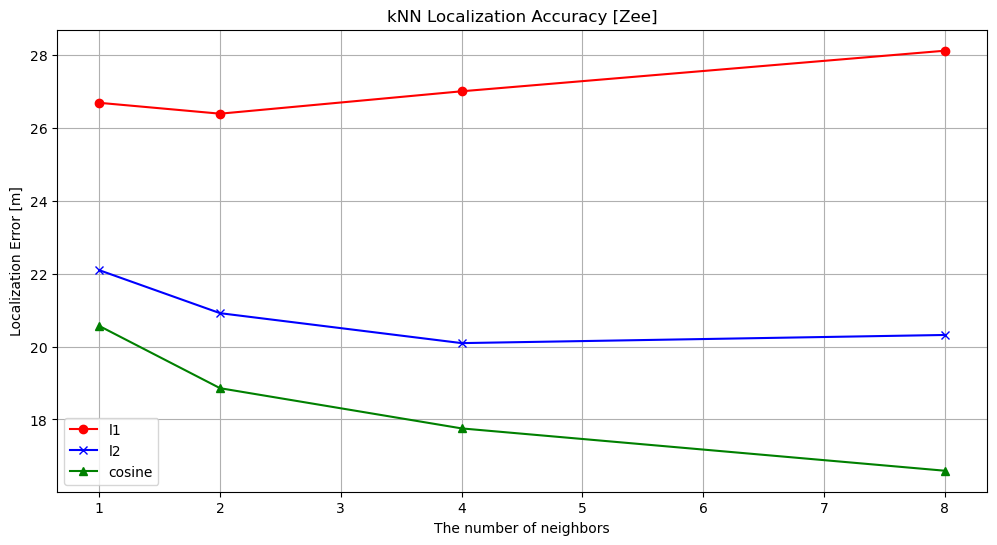

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = result_df.loc[(result_df["param_min_rss"] == -85) & (result_df["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy [Zee]")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()

In [164]:
result_df[result_df["mean"] == result_df["mean"].min()]

,count,mean,std,p5,p10,p25,p50,p75,p90,p95,param_min_rss,param_metric,param_n_neighbors
47,1601,18.085244,15.854124,3.475347,5.07213,8.301448,13.383495,21.411331,34.962746,57.29432,-85,cosine,8


* Multi-floor Error Analysis

In [60]:
pred_df = pd.concat([pd.read_csv(file) for file in glob("../../data/zee_scene_3/pred_*.csv")])

In [61]:
avg_pred_df_error = pred_df[pred_df["param_min_rss"] == -85].groupby(["param_metric", "param_n_neighbors"]).agg({"mean": "mean"}).reset_index()

In [62]:
avg_pred_df_error

,param_metric,param_n_neighbors,mean
0,cosine,1,20.734915
1,cosine,2,19.348204
2,cosine,4,18.507598
3,cosine,8,17.815721
4,l1,1,26.598170
5,l1,2,26.058671
6,l1,4,26.238327
7,l1,8,27.514998
8,l2,1,23.386570
9,l2,2,22.455127


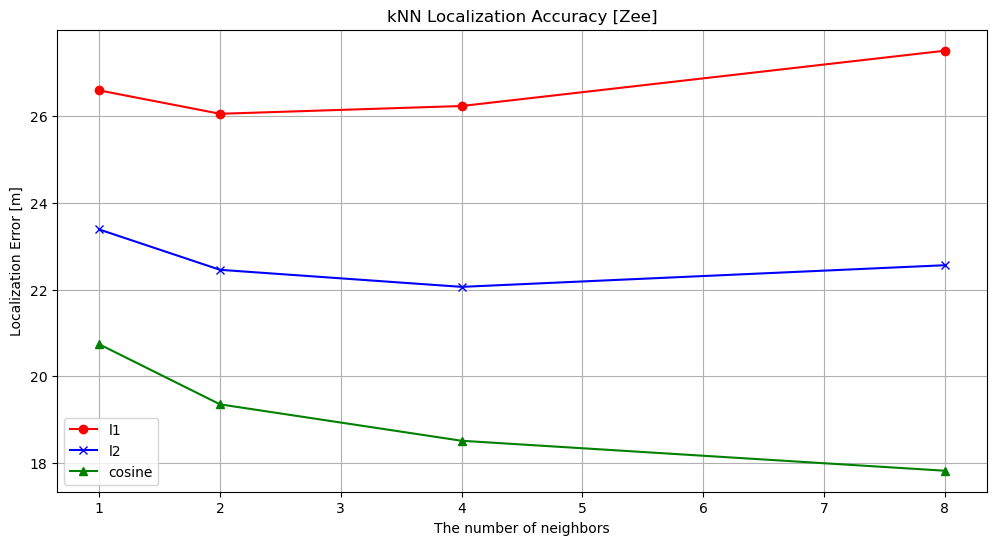

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = avg_pred_df_error.loc[(avg_pred_df_error["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy [Zee]")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()

In [64]:
gt_df = pd.concat([pd.read_csv(file) for file in glob("../../data/zee_scene_3/gt_*.csv")])

In [65]:
avg_gt_df_error = gt_df[gt_df["param_min_rss"] == -85].groupby(["param_metric", "param_n_neighbors"]).agg({"mean": "mean"}).reset_index()

In [66]:
avg_gt_df_error

,param_metric,param_n_neighbors,mean
0,cosine,1,10.522255
1,cosine,2,9.865482
2,cosine,4,9.535802
3,cosine,8,9.539086
4,l1,1,18.239984
5,l1,2,18.372664
6,l1,4,19.341573
7,l1,8,21.863467
8,l2,1,14.648239
9,l2,2,14.288038


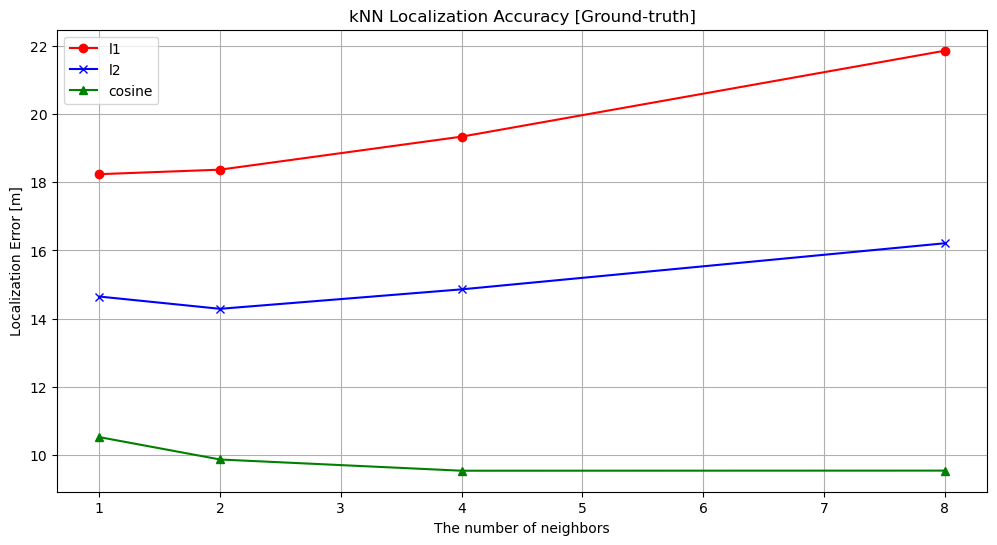

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = avg_gt_df_error.loc[(avg_gt_df_error["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy [Ground-truth]")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()